In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
import json
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

In [2]:
import hdbscan
import nltk
import numpy as np
import pandas as pd
import random
import re
import spacy
import textacy

from gmplot import gmplot
from mapsplotlib import mapsplot as mplt
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag_sents
from pymprog import *
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric

In [3]:
import pandas as pd


In [4]:
fname = "all_tweets.json"

In [5]:
list_tweets = []
count = 0 
sum = 1000
with open(fname,encoding="utf8") as f:
    #head = [next(f) for x in range(512000)]
    for line in f:
        try:
            tweet = json.loads(line)
        except:
            pass
        list_tweets.append(tweet)
        count+=1
        if count==sum:
            print(count)
            sum*=2

1000
2000
4000
8000
16000
32000
64000
128000
256000
512000
1024000


In [6]:
list_tweets[0].keys()

dict_keys(['contributors', 'coordinates', 'created_at', 'display_text_range', 'entities', 'favorite_count', 'favorited', 'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place', 'possibly_sensitive', 'retweet_count', 'retweeted', 'source', 'truncated', 'user'])

In [7]:
df = pd.DataFrame(data=[tweet["full_text"] for tweet in list_tweets], columns=['tweets'])
df['created_at'] = np.array([tweet["created_at"] for tweet in list_tweets])
df['id'] = np.array([tweet["id"] for tweet in list_tweets])
df['rt'] = np.array([tweet["retweeted"] for tweet in list_tweets])
df['lang'] = np.array([tweet["lang"] for tweet in list_tweets])

In [8]:
df.head()

,tweets,created_at,id,rt,lang
0,Could you ever perform a kind act for a bad boss? http://t.co/T5RNfO3F #tellyourboss,Wed Oct 10 00:00:01 +0000 2012,255819941796782080,False,en
1,RT @Zaviyayy: Kiss her right in the middle of a sentence. Girls love that.,Wed Oct 10 00:00:00 +0000 2012,255819937665409020,False,en
2,congrats tw on an AMA nomination #loveyou #congrats #TWFanmiIy,Wed Oct 10 00:00:00 +0000 2012,255819937870921730,False,en
3,"Lmao wait, did you think it was something other than what it really is??? http://t.co/Au7zIVT1",Wed Oct 10 00:00:00 +0000 2012,255819933596930050,False,en
4,RT @overlyxclusive: and part of growing up is realizing that everybody does not grow up with you...,Wed Oct 10 00:00:01 +0000 2012,255819941884862460,False,en


## Remove tweets that are not in English

Text(0.5, 1.0, 'Tweets 2012')

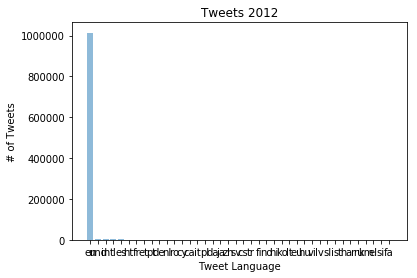

In [9]:
import matplotlib.pyplot as plt
# plots number of tweets in each language
counts = df['lang'].value_counts()
plt.bar(counts.index, counts, align='center', alpha=0.5)
plt.xlabel('Tweet Language')
plt.ylabel('# of Tweets')
plt.title('Tweets 2012')

In [10]:
import datetime
from time import strptime
strptime('Oct','%b').tm_mon

10

In [11]:
df["created_at"][0]

'Wed Oct 10 00:00:01 +0000 2012'

In [12]:
x = str(datetime.datetime(2020, 12, 17)).split()[0]
print(x)

2020-12-17


In [13]:
temp = df["created_at"][0].split(" ")
# print(temp[5])
# print(int(strptime(temp[1],'%b').tm_mon))
# print(temp[2])
x = str(datetime.datetime(int(temp[5]),int(strptime(temp[1],'%b').tm_mon),int(temp[2]))).split()[0]
print(x)

2012-10-10


In [14]:
def create_date(text):
    temp = text.split(" ")
    x = str(datetime.datetime(int(temp[5]),int(strptime(temp[1],'%b').tm_mon),int(temp[2]))).split()[0]
    return x
df['date'] = df['created_at'].apply(lambda x: create_date(x))

In [15]:
df['time'] =  np.array([tweet.split()[3] for tweet in df["created_at"]])

In [16]:
df["date"].head()

0    2012-10-10
1    2012-10-10
2    2012-10-10
3    2012-10-10
4    2012-10-10
Name: date, dtype: object

# Flagging all potential eventful tweets

In [17]:
# converting to a Datetime format by hour
df2 = df.copy()
df2['Datetime']= pd.to_datetime(df2['date'].apply(str)+' '+df2['time'].apply(lambda x: x.split(':')[0]) + df2['time'].apply(lambda x: x.split(':')[1]))
#df2['DateHour'] = pd.to_datetime(df2['date'].apply(str)+' '+df2['time'].apply(lambda x: x.split(':')[0])+':00')

tableFlag=[]


In [18]:
data_sorted = df2.sort_values(by=['date'],inplace=False)
data_sorted = data_sorted.reset_index(drop=True)

list_date = []
for temp in data_sorted["date"]:
    list_date.append(temp)

list_date = list(dict.fromkeys(list_date))
list_date

['2012-10-10']

In [19]:
tableFlag = []
count = 0
for i in range(len(list_date)):
    dfchange = df2.loc[df2['date']==list_date[i]]
    ts = dfchange.set_index('date')
    vc = ts.groupby("Datetime").count()
    col = ['id']
    vc2 = vc[col]
    ##calculating threshold to flag hours with more tweets
    th = vc2['id'].mean()+2*vc2['id'].std()
    #iterating through each row to find flags
    for index, row in vc2.iterrows():
        if (row["id"]>th):
            tableFlag.append([i,index])
            count+=1
print("Count: ",count)
tableFlag

Count:  27


[[0, Timestamp('2012-10-10 00:45:00')],
 [0, Timestamp('2012-10-10 00:46:00')],
 [0, Timestamp('2012-10-10 00:47:00')],
 [0, Timestamp('2012-10-10 01:16:00')],
 [0, Timestamp('2012-10-10 01:17:00')],
 [0, Timestamp('2012-10-10 01:18:00')],
 [0, Timestamp('2012-10-10 01:19:00')],
 [0, Timestamp('2012-10-10 01:20:00')],
 [0, Timestamp('2012-10-10 01:21:00')],
 [0, Timestamp('2012-10-10 01:22:00')],
 [0, Timestamp('2012-10-10 01:27:00')],
 [0, Timestamp('2012-10-10 01:28:00')],
 [0, Timestamp('2012-10-10 01:29:00')],
 [0, Timestamp('2012-10-10 01:30:00')],
 [0, Timestamp('2012-10-10 01:38:00')],
 [0, Timestamp('2012-10-10 01:39:00')],
 [0, Timestamp('2012-10-10 01:40:00')],
 [0, Timestamp('2012-10-10 01:41:00')],
 [0, Timestamp('2012-10-10 01:42:00')],
 [0, Timestamp('2012-10-10 01:43:00')],
 [0, Timestamp('2012-10-10 01:49:00')],
 [0, Timestamp('2012-10-10 01:50:00')],
 [0, Timestamp('2012-10-10 01:51:00')],
 [0, Timestamp('2012-10-10 01:52:00')],
 [0, Timestamp('2012-10-10 01:53:00')],


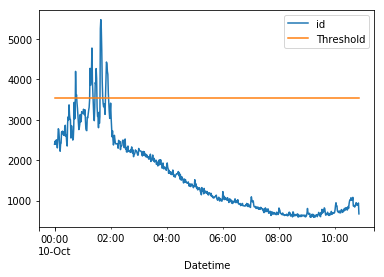

In [20]:
# graphing the threshold vs hourly tweet occurences
dfchange = df2.loc[df2['date'] != -1]
ts = dfchange.set_index('Datetime')
vc = ts.groupby('Datetime').count()
col = ['id']
vc2 = vc[col]
vc3 = vc2.copy()
th = vc2['id'].mean()+2*vc2['id'].std()
for index, row in vc2.iterrows():
    if (row["id"]>th):
        tableFlag.append([i, index])
        count+=1

vc4 = vc2.copy()
vc4.rename(columns={'id':'Hourly'},inplace=True)
vc3['id'] = th
vc3.rename(columns={'id':'Threshold'},inplace=True)

ax = vc2.plot()
vc3.plot(ax = ax)

In [21]:
# retrieve tweets associated with flagged timestamp
df2['event_id'] = -1
for index, array in enumerate(tableFlag):
    cluster = array[0]
    timestamp = array[1]
    df2['event_id'] = (np.where((df2['Datetime'] == timestamp), index, df2["event_id"]))

In [22]:
df2.to_pickle('events.pkl')

In [23]:
events = pd.read_pickle('events.pkl')

In [24]:
df2.columns

Index(['tweets', 'created_at', 'id', 'rt', 'lang', 'date', 'time', 'Datetime',
       'event_id'],
      dtype='object')

## Find Similar Tweets

In [62]:
from sklearn.cluster import DBSCAN
import pandas as pd
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

num_clusters = 100
stemmer = SnowballStemmer("english")

<h3> Remove hashtags,mentions,retweets from the tweet and import them to a new column </h3>

In [26]:
def remove_patterns(input_txt,mentions,hashtags,RT):
    m = re.findall(mentions, input_txt)
    h = re.findall(hashtags,input_txt)
    r = re.findall(RT,input_txt)
    u = re.findall(r"http\S+",input_txt)
    mention_list = []
    hashtag_list = []
    url_list = []
    rt1 = 0
    
    
    for i in u:
        url_list.append(i)
        #input_txt = re.sub(i,'',input_txt)
    input_txt = re.sub(r"http\S+",'',input_txt)
    for i in m:
        mention_list.append(i)
        input_txt = re.sub(i, '', input_txt)
    for i in h:
        hashtag_list.append(i)
        input_txt = re.sub(i,'',input_txt)
    if r!=0 :
        rt1 = 1
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    #Some json
    x = {"input_text" : input_txt,"user_mentions":mention_list,"hashtags":hashtag_list,"is_RT":rt1,"is_URL":url_list}
    #y = json.dumps(x)
    return x

temp = np.vectorize(remove_patterns)(df2['tweets'],"@[\w]*","#[\w]*","RT")

In [27]:
#print(df["Orig_Tweet"][12])
df2["text"] = np.array([text["input_text"] for text in temp])
df2["hashtag"] = np.array([text["hashtags"] for text in temp])
df2["new_mentions"] = np.array([text["user_mentions"] for text in temp]) 
df2["RT"] = np.array([text["is_RT"] for text in temp])
df2["URL"] = np.array([text["is_URL"] for text in temp])
df2.head()

,tweets,created_at,id,rt,lang,date,time,Datetime,event_id,text,hashtag,new_mentions,RT,URL
0,Could you ever perform a kind act for a bad boss? http://t.co/T5RNfO3F #tellyourboss,Wed Oct 10 00:00:01 +0000 2012,255819941796782080,False,en,2012-10-10,00:00:01,2012-10-10,-1,Could you ever perform a kind act for a bad boss?,[#tellyourboss],[],1,[http://t.co/T5RNfO3F]
1,RT @Zaviyayy: Kiss her right in the middle of a sentence. Girls love that.,Wed Oct 10 00:00:00 +0000 2012,255819937665409020,False,en,2012-10-10,00:00:00,2012-10-10,-1,: Kiss her right in the middle of a sentence. Girls love that.,[],[@Zaviyayy],1,[]
2,congrats tw on an AMA nomination #loveyou #congrats #TWFanmiIy,Wed Oct 10 00:00:00 +0000 2012,255819937870921730,False,en,2012-10-10,00:00:00,2012-10-10,-1,congrats tw on an AMA nomination,"[#loveyou, #congrats, #TWFanmiIy]",[],1,[]
3,"Lmao wait, did you think it was something other than what it really is??? http://t.co/Au7zIVT1",Wed Oct 10 00:00:00 +0000 2012,255819933596930050,False,en,2012-10-10,00:00:00,2012-10-10,-1,"Lmao wait, did you think it was something other than what it really is???",[],[],1,[http://t.co/Au7zIVT1]
4,RT @overlyxclusive: and part of growing up is realizing that everybody does not grow up with you...,Wed Oct 10 00:00:01 +0000 2012,255819941884862460,False,en,2012-10-10,00:00:01,2012-10-10,-1,: and part of growing up is realizing that everybody does not grow up with you. some are slow t...,[],[@overlyxclusive],1,[]


<h3> Remove punctuation </h3>

In [28]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
def remove_punct(text):
    temp = string.punctuation+"…"
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

df2['Tweet_punct'] = df2['text'].apply(lambda x: remove_punct(x))

<h3>Tokenization</h3>

In [30]:
def tokenization(text):
    text = re.split('\W+', text)
    #text = nltk.word_tokenize(text)
    temp=[]
    for i in text:
        if i!='':
            temp.append(i)
    return temp

df2['Tweet_tokenized'] = df2['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
df2.head()

,tweets,created_at,id,rt,lang,date,time,Datetime,event_id,text,hashtag,new_mentions,RT,URL,Tweet_punct,Tweet_tokenized
0,Could you ever perform a kind act for a bad boss? http://t.co/T5RNfO3F #tellyourboss,Wed Oct 10 00:00:01 +0000 2012,255819941796782080,False,en,2012-10-10,00:00:01,2012-10-10,-1,Could you ever perform a kind act for a bad boss?,[#tellyourboss],[],1,[http://t.co/T5RNfO3F],Could you ever perform a kind act for a bad boss,"[could, you, ever, perform, a, kind, act, for, a, bad, boss]"
1,RT @Zaviyayy: Kiss her right in the middle of a sentence. Girls love that.,Wed Oct 10 00:00:00 +0000 2012,255819937665409020,False,en,2012-10-10,00:00:00,2012-10-10,-1,: Kiss her right in the middle of a sentence. Girls love that.,[],[@Zaviyayy],1,[],Kiss her right in the middle of a sentence Girls love that,"[kiss, her, right, in, the, middle, of, a, sentence, girls, love, that]"
2,congrats tw on an AMA nomination #loveyou #congrats #TWFanmiIy,Wed Oct 10 00:00:00 +0000 2012,255819937870921730,False,en,2012-10-10,00:00:00,2012-10-10,-1,congrats tw on an AMA nomination,"[#loveyou, #congrats, #TWFanmiIy]",[],1,[],congrats tw on an AMA nomination,"[congrats, tw, on, an, ama, nomination]"
3,"Lmao wait, did you think it was something other than what it really is??? http://t.co/Au7zIVT1",Wed Oct 10 00:00:00 +0000 2012,255819933596930050,False,en,2012-10-10,00:00:00,2012-10-10,-1,"Lmao wait, did you think it was something other than what it really is???",[],[],1,[http://t.co/Au7zIVT1],Lmao wait did you think it was something other than what it really is,"[lmao, wait, did, you, think, it, was, something, other, than, what, it, really, is]"
4,RT @overlyxclusive: and part of growing up is realizing that everybody does not grow up with you...,Wed Oct 10 00:00:01 +0000 2012,255819941884862460,False,en,2012-10-10,00:00:01,2012-10-10,-1,: and part of growing up is realizing that everybody does not grow up with you. some are slow t...,[],[@overlyxclusive],1,[],and part of growing up is realizing that everybody does not grow up with you some are slow to ...,"[and, part, of, growing, up, is, realizing, that, everybody, does, not, grow, up, with, you, som..."


<h3>Remove stopwords</h3>

In [31]:
stopword = nltk.corpus.stopwords.words('english')

In [32]:
def remove_stopwords(text):
     text = [word for word in text if word not in stopword]
     return text
    
df2['Tweet_nonstop'] = df2['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))

In [33]:
print(df2["tweets"][2])
print(df2['Tweet_nonstop'][2])

congrats tw on an AMA nomination #loveyou #congrats #TWFanmiIy
['congrats', 'tw', 'ama', 'nomination']


<h3>Stemming and Lammitization </h3>

In [34]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

In [35]:
df2.columns

Index(['tweets', 'created_at', 'id', 'rt', 'lang', 'date', 'time', 'Datetime',
       'event_id', 'text', 'hashtag', 'new_mentions', 'RT', 'URL',
       'Tweet_punct', 'Tweet_tokenized', 'Tweet_nonstop'],
      dtype='object')

In [36]:
# Stemming is the process of breaking a word down into its root.
stemmer = SnowballStemmer('english')
stops = set(stopwords.words("english"))

In [37]:
def stemming_to_sent(words):
    stemmed_words = [stemmer.stem(w) for w in words]
    return(" ".join(stemmed_words))
def stemming_to_words(words):
    stemmed_words = [stemmer.stem(w) for w in words]
    return stemmed_words

In [38]:
df2["Stem_sent"] = np.array([stemming_to_sent(temp) for temp in df2["Tweet_nonstop"]])

In [39]:
df2["Stem_words"] = np.array([stemming_to_words(temp) for temp in df2["Tweet_nonstop"]])

<h3>Creating Features from a Bag of Words (Using scikit-learn)</h3>

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

In [41]:
def getBagofWords(clean_train,i):
    # Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
    vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,stop_words = None,max_features = 5000)
    # fit_transform() does two functions: First, it fits the model 
    # and learns the vocabulary; second, it transforms our training 
    # data into feature vectors. 
    # Input to fit_transform(): a list of strings 
    # Output: a document-term sparse matrix [n_samples, n_features]
    train_data_features = vectorizer.fit_transform(clean_train)

    # Numpy arrays are easy to work with, so convert the result to an array
    train_data_features = train_data_features.toarray()
    return {"train_data_features":train_data_features,"vectorizer":vectorizer,"event_id":i,"clean_train":clean_train}

In [42]:
maxn = df2["event_id"].max()+1
x_object = []
for i in range(maxn):
    strd=[]
    dfchange = df2.loc[df2["event_id"]==i]
    for temp in dfchange["Stem_sent"]:
        strd.append(temp)
    #print(strd)
    if strd:
        x_object.append(getBagofWords(strd,i))
    #getBagofWords(strd)

In [43]:
train_data_features = x_object[0]["train_data_features"]
train_data_features.shape

(4195, 4626)

In [44]:
vectorizer = x_object[0]["vectorizer"]
vocab = vectorizer.get_feature_names()
print(vocab)

['aam', 'aaron', 'ab', 'abalda', 'abbi', 'abbott', 'abbout', 'abercrombi', 'abigail', 'abl', 'ablaz', 'abort', 'absenc', 'absolut', 'absoul', 'abus', 'academ', 'accent', 'accept', 'accessori', 'accident', 'accompani', 'accord', 'account', 'accus', 'ace', 'acey', 'ach', 'achiev', 'acid', 'ackin', 'acl', 'acn', 'across', 'act', 'actinn', 'action', 'activ', 'activerain', 'actress', 'actual', 'acura', 'ad', 'ada', 'adam', 'add', 'addict', 'adel', 'adhd', 'adida', 'adjust', 'adm', 'admit', 'ador', 'advanc', 'adventur', 'advertis', 'advic', 'advisor', 'af', 'affair', 'affili', 'affirm', 'afford', 'afli', 'afraid', 'africa', 'african', 'afterthat', 'agai', 'age', 'agenc', 'ago', 'aguilera', 'ah', 'aha', 'ahead', 'ahh', 'ahha', 'ahhh', 'ai', 'aid', 'aill', 'aim', 'aint', 'air', 'airport', 'aj', 'aja', 'ajcov', 'aka', 'al', 'alabama', 'alarm', 'albert', 'album', 'alcohol', 'aldean', 'alex', 'algo', 'alien', 'alil', 'aliv', 'allah', 'allan', 'allat', 'allen', 'allerg', 'allimport', 'allinight', 

In [45]:
def getTFIDFAndSim(tweets):
    vect = TfidfVectorizer(max_df=0.8, max_features=200000,stop_words='english', use_idf=True, ngram_range=(1,3))
    tfidf = vect.fit_transform(tweets)
    sim = (tfidf * tfidf.T).A
    return tfidf, sim

In [46]:
def stemAndTokenize(tweets):   
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in tweets:
        allwords_stemmed = tokenize_and_stem(i) # for each item in 'synopses', tokenize/stem
        totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)
    
    return totalvocab_stemmed, totalvocab_tokenized

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [47]:
def new_clean_data(i,df2):
    sent = ""
    for temp in df2["Stem_words"].get(i):
        sent+= temp + " "
    for temp in df2["hashtag"].get(i):
        sent+= temp + " "
    for temp in df2["new_mentions"].get(i):
        sent+= temp+ " "
    for temp in df2["URL"].get(i):
        sent+= temp + " "
    return sent

df2["clean_data"] = np.array([new_clean_data(i,df2) for i in range(df2.shape[0])])

In [65]:
def findSimilarTweets(tweets, tfidf,e):
    clustering = DBSCAN(eps=e, min_samples=3).fit(tfidf)
    #clustering = hdbscan.HDBSCAN(min_cluster_size=2).fit(tfidf)

    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove

    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters

    pd.options.display.max_colwidth = 100

    cls = []
    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append(tweetsInCluster)
            #print("cluster: ",i)
            print("Cluster", i, ":", tweetsInCluster.shape[0])
            #print(tweetsInCluster.shape[0])
            print(tweetsInCluster['tweets'])

            #    return True
        
    return cls

In [55]:
maxn = df2["event_id"].max()
tweetsPerEvent = []
for i in range(0, maxn):
    tweetsPerEvent.append(df2[df2['event_id'] == i])
    #tweetsPerEvent[i]["Clean_data"] = np.array([temp for temp in df2[df2['event_id'] == i]["Orig_Tweet"]])

In [68]:
count = 0
df = pd.DataFrame();
    
# For each spike, clean the tweets, stem and tokenize the tweets, and find the TF-IDF vectors for the tweets. Then cluster
# on the vectors to find similar tweets. If clusters are found, then take the largest cluster to find the tweets that define
# the event.
for i in range(0, len(tweetsPerEvent)):
    if(tweetsPerEvent[i].shape[0] < 10):
        continue
    
    
    
    
    count += 1
    #tweets = cleanData(tweetsPerEvent[i])
    #tweetsContent = tweets.copy()['clean_data']
    tweets = tweetsPerEvent[i]
    tweetsContent = tweets.copy()['clean_data']
    tfidf, sim = getTFIDFAndSim(tweetsContent)
    #totalvocab_stemmed, totalvocab_tokenized = stemAndTokenize(tweetsContent)
    print("Event", i, ":")
    print("Tweets: ",tweetsPerEvent[i].shape[0])
    #print(tweetsPerEvent[i]['Orig_Tweet'])
    if(findSimilarTweets(tweets, tfidf,0.95)):
        df = pd.concat([df, tweetsPerEvent[i]])
    print("\n")
    
print(count)

Event 27 :
Tweets:  4195
Cluster 0 : 279
120993                                        All I want for my birthday is a BIG BOOTY HOEE!!
121045                                          ALL I WANT FOR MY BIRTHDAY IS A BIG BOOTY GUH!
121063                                         all i want for my birthday is a big booty hoe .
121086                                         She got a big booty , so I call her big booty !
121114                                           All i want for my birthday is a big booty hoe
121117                                           All I want for my birthday is a big booty hoe
121125                                     all i want for my birthday is a big booty hoe ! lol
121134                                       all i want for my birthday is  big booty hoe lmao
121135                                        All I want for my birthday is a big booty hoe! 😁
121148                                           All I Want For My Birthday Is A Big Booty Hoe
121178   

Name: tweets, dtype: object
Cluster 2 : 29
121024                  This nigga got a choir lmfao
121043                  These niggas got a choir ? 😲
121221             2 chainz got a choir and shit lol
121409        Why df 2 chainz got a choir ??? -____-
121415                        Not A Choir !!!!! LMAO
121455                    2 chainz got the choir lol
121498                  This nigga got a choir! lmao
121534    no they don't have "choir" in the back LOL
121709                 This nigga got a choir . Ctfu
121739           LMAOOO , 2 Chainz Got Him A Choir .
122123                        This nigga got a choir
122201                  2 chainz got the choir LMBO!
122567           2 chainz got a choir behind him wtf
122743                      Why He Got This Choir ??
122853                        This nigga got a choir
123026                       Df 2chainz got goin lol
123177                     Why is there a choir? LOL
123182    This nigga got a choir in the back.....smh
123

Name: tweets, dtype: object
Cluster 11 : 11
121229                      2 Chainz dancing and shit lmao!
121777                          2Chainz cant dance for shit
122633        2chainz cannot dance for shit wtf was that 😳😂
122649                                  Cant dance for shit
122761                       2 Chainz Cant Dance 4 Shit Lol
122772                   Ctfuu 2chainz Can't DANCE For Shit
123062    2 Chainz can't dance for shit! 😂😂😂😂 #HipHopAwards
123404                    2Chainz Cant Dance For Shit . Lol
123480                     2 chainz be dancing and shit lol
123850                      2chainz can't dance for shit 😂😂
124347                     2chainz can't Dance for shit!!!!
Name: tweets, dtype: object
Cluster 12 : 3
121237              : 2 Chainz ! #HipHopAwards
122550    I can't wit 2 chainz😂😔 #HipHopAwards
123957                2CHAINZ!!! #hiphopawards
Name: tweets, dtype: object
Cluster 13 : 3
121257      This My Song
122635    This my song !
124365     this me 

Name: tweets, dtype: object
Cluster 35 : 3
121976    2 Chainz is goofy lmao
122038      Lol 2chainz is goofy
122254          2chainz so goofy
Name: tweets, dtype: object
Cluster 36 : 3
122259    U.S. sues Wells Fargo in mortgage fraud case - (Reuters) - The U.S. government filed a civil mor...
124387    Reuters U.S. sues Wells Fargo in mortgage fraud case - (Reuters) - The U.S. government filed a c...
124390    Reuters U.S. sues Wells Fargo in mortgage fraud case - (Reuters) - The U.S. government filed a c...
Name: tweets, dtype: object
Cluster 37 : 11
121763                           2Chainz Got The Church Choir Doe
121834              Why they got on church choir robes oh,my,gawd
122293                                       Not the church choir
122465    RT @ShurALL_Yours: They got the church choir on stage !
122624                  Really!! A Church Choir In This Song Lmao
122949                      The church choir to that song though?
123395                  Do they have a church

Name: tweets, dtype: object


Event 28 :
Tweets:  3575
Cluster 0 : 5
125160                 RT @2ChainzLyrics: Hair Weave Killa!! #BetHipHopAwards
126672                                                       Hair weave killa
126991    Yea..bet would show the girls with no hair sayin "hair weave killa"
127725                 RT @2ChainzLyrics: Hair Weave Killa!! #BetHipHopAwards
127764                                   RT @Ayoo_Emonica: Hair weave KILLA(;
Name: tweets, dtype: object
Cluster 1 : 5
125171             My niggas 2 chainz be hype af
126304             2chainz hype af #HipHopAwards
126660        That nigga Chainz hype af ...thats
127026    2 Chainz be getting me hype af though.
127967                           2chainz hype af
Name: tweets, dtype: object
Cluster 2 : 41
125219                                 RT @GET_YA_HOE_MANE: I gt a big booty so just call me BIG BOOTY!!! 💃💃💃
125287                                                              I Got A BIG Booty So Call Me Big 

Name: tweets, dtype: object
Cluster 9 : 33
125374                                    All I want for my birthday is A BIG BOOTY HOE !!!
125480                                      All I want for my birthday is a big booty hoe !
125495    *turns t.v up* all i want for my birthday is a big booty girl *start 2 stepping *
125586                                        All I want for my birthday is a big booty hoe
125615                                       All I want for my birthday is a big booty hoe😍
125637                                      All I want for my birthday is a big booty girl!
125638                           All I want for my birthday is a big booty hoe ( oct. 28th)
125654                                    All I want for my birthday is a big booty period.
125712                                                        All I want is a big booty hoe
125745                        RT @BlowMee3x: All I Want For My Birthday Is A BIG BOOTY HOE!
125750                               

Name: tweets, dtype: object
Cluster 18 : 3
125742    RT @HipHopAwards: "I'm Frank Ocean at a Chik-Fil-A, I never get served!" - @TalibKweli #HipHopAw...
127203    RT @HipHopAwards: "I'm Frank Ocean at a Chik-Fil-A, I never get served!" - @TalibKweli #HipHopAw...
128688    RT @HipHopAwards: "I'm Frank Ocean at a Chik-Fil-A, I never get served!" - @TalibKweli #HipHopAw...
Name: tweets, dtype: object
Cluster 19 : 6
125803     RT @Hotboylucas: Damn Talib Kweli said I'm Frank Ocean at a Chic-Fil-A ill never get served..
126190      RT @_DOPExInsanity: "Im like  frank ocean in a chic-fil-a ill neva get served" Talib SNAPPED
126365             RT @CourtSideCoolin: "Frank Ocean at chic-fil-a , I'll never get served"- 😂😂😂😂😂😂😭😭😭😭😭
126496    RT @FaaabulousMe_: 😳 He said "I'm Frank Ocean at a Chic-fil-a, I'll never get served" ...damn.
128293                 RT @GQ2_BSMOOTH: Nigga said I'm Frank Ocean at a Chic-Fil-A ill never get served.
128347                                     "I'm like Frank 

Name: tweets, Length: 75, dtype: object
Cluster 31 : 5
126415    RT @2ChainzLyrics: TRUUU
126830    RT @2ChainzLyrics: TRUUU
127817    RT @2ChainzLyrics: TRUUU
128320    RT @2ChainzLyrics: TRUUU
128415    RT @2ChainzLyrics: TRUUU
Name: tweets, dtype: object
Cluster 32 : 3
126439     PULL UP TO THA SCENE WIT MA CEILIN MISSIN
127850    Pull up to da scene wit my ceilin missin !
128256      Pull up to da scene wit my ceilin missin
Name: tweets, dtype: object
Cluster 33 : 4
126548                                                          When I die bury me inside the GUCCI stoeee !!
126857                                                            when i died bury me inside a Gucci store :)
127019                                                               When I die bury me inside the gucci sto'
128090    when i die bury me inside the Gucci store... all i want for my birthday is big bootie ho!!! #2ch...
Name: tweets, dtype: object
Cluster 34 : 6
126792              i know he aint playing

Name: tweets, Length: 69, dtype: object
Cluster 5 : 5
128840               This my shit!
130394             This my shit!!!
130584    Your on some other shit.
130798          This my shit too !
130822         This my shit!!!!!!!
Name: tweets, dtype: object
Cluster 6 : 4
128868                              2 chainz should perform Dope Peddler
129506    RT @getemdaddy__: I WANT 2 CHAINZ TO PERFORM DOPE PEDDLER YO!!
129553                                     He should of did dope peddler
132353        RT @DoItLike_APro: He Should Have Performed Dope Peddler .
Name: tweets, dtype: object
Cluster 7 : 3
128893        i love 2 chainz dreads tho :)
129033    I'm Loving 2 Chainz Dreads Though
129144                     Them dreads tho.
Name: tweets, dtype: object
Cluster 8 : 7
128906      RT @BoutaCop_ALEXIS: I'm different yea I'm different!
129272              I'm different yea I'm different *beefs it up*
130054     IM DIFFERENT YEA IM DIFFERENT LMAO THIS SONG IS ______
130103    I'm different

Name: tweets, dtype: object
Cluster 22 : 29
129550                              Ass so big , i told her to look back at it .
130167                                                         Told look back it
130273                                            I told her look back at it !!!
130363                                   Ass so big I told her look back at it.!
130403                                       ass so big told her look back at it
130666                                     Ass so big I told her look back at it
130672                                      Ass so big told her look back at it!
130735                                     Ass so big I told her look back at it
130833                                Ass so big i told her to look back at it .
130984                                    - ass so big he told me look bk at it!
131092                                   Ass so big , told her look back at it !
131207                                  Ass So Big Told Her To Lo

Name: tweets, dtype: object
Cluster 1 : 5
218608    Turn on the lights! Future !!! #betHipHopAwards2012
219089                           Turn on the lights ---Future
220467                           Turn on the lights- Future😍👌
222314             Turn on the lights so I can see my future!
222463                       Turn On The Lights - Future &gt;
Name: tweets, dtype: object
Cluster 2 : 17
218610         Don't get to thirsty
219270        Don't get too thirsty
219445     Don't get too thirsty...
219609        Don't get too thirsty
219684    Don't get too thirsty -8-
219750             dont get thirsty
219790          dont get to thirsty
220028        Don't Get Too Thirsty
220162         Don't get to thirsty
220217          Dont get to thirsty
220393         Dont get too thirsty
220419         Don't get to thirsty
220670      Don't get to thirsty ..
220697      Don't get too thirsty .
220700         Don't get to thirsty
221384        Don't get too thirsty
222020       Don't get to thi

Name: tweets, dtype: object
Cluster 15 : 3
218738             Future Looking Too Good!
219229          FUTURE am looking for you!!
220775    future look good rite there tho..
Name: tweets, dtype: object
Cluster 16 : 3
218755     WHAT TYPE OF DRINK YOU WANT BRUH
219284     What type of drink you want girl
221439    What type of drink you want girl?
Name: tweets, dtype: object
Cluster 17 : 9
218780                      Future is sexy
218989                  Future sexy ass 😍😘
218991                     Future Too Sexy
219603               Future is so sexy.!!!
220422                     future is sexy!
220896                  Future is so sexy.
221494    RT @Yanna_C9M: Future sexy ass!!
221555             Future Sexy Ass :)) lol
222034           And Future sexy AS FUCK !
Name: tweets, dtype: object
Cluster 18 : 5
218805        my husband FUTURE 😍😘❤❤
219878    Other husband FUTURE yummy
220294           My husband Future ♥
220634            That's my husband.
220713        My Husband Perf

Name: tweets, dtype: object
Cluster 23 : 3
219005    if you wanna live better we can buy a crib wherever * future voice *
219840                "If you wanna live better we can buy a crib where ever "
219954                 When ya wanna live better , we can buy a crib wherever!
Name: tweets, dtype: object
Cluster 24 : 5
219039    RT @SnoopDogg: #respectthewest
219209    RT @SnoopDogg: #respectthewest
219234    RT @SnoopDogg: #respectthewest
220002    RT @SnoopDogg: #respectthewest
220273    RT @SnoopDogg: #respectthewest
Name: tweets, dtype: object
Cluster 25 : 3
219053        Turn on the lights #HipHopAwards
219776    Turn off The Lights 😋\n#HipHopAwards
219999        turn on the lights #HipHopAwards
Name: tweets, dtype: object
Cluster 26 : 3
219054    RT @LivingLegendO_o: Future done slick turned into a R&amp;B artist lmaoo
219487    RT @LivingLegendO_o: Future done slick turned into a R&amp;B artist lmaoo
219670    RT @LivingLegendO_o: Future done slick turned into a R&amp;B artist

Name: tweets, dtype: object
Cluster 48 : 3
220144                       And the one night I need someone to talk too no ones there for me.
220703                                                              Smh I need someone talk too
221835    “@ThatGirlSaraaa: And the one night I need someone to talk too no ones there for me.”
Name: tweets, dtype: object
Cluster 49 : 3
220151        Turn on the lights , he looking for me
221014    Turn on the lights in looking for him too!
222248       Turn On The Lights He Look For Me ♥ lol
Name: tweets, dtype: object
Cluster 50 : 3
220302                                                   West Coast
220486                                             West coast kid ✊
222067    WEST COAST!!!! WEST COAST!!! Ya'll KNOW YA'LL HEARD IT!!!
Name: tweets, dtype: object
Cluster 51 : 3
220304    RT @chicagobulls: At the half, #Bulls trail @memgrizz 52-49. Deng 14pts 4reb, Noah 7pts 4reb. 15...
220606    RT @chicagobulls: At the half, #Bulls trail @memgrizz 52-

Name: tweets, Length: 207, dtype: object
Cluster 1 : 39
222862                                      I wanna tell the world about us just do they could get jealous
222869                               I wanna tell the world about you just so they could get jealous &lt;3
222882                                     I Wanna Tell the World About You Just So They Can Get Jealous ☺
222947                                       I wanna tell the world about you just so they can get jealous
222951              RT @chyniamichelle: I wanna tell the world about you just so they can get jealous ❤❤❤❤
222954                        RT @WhoNeedsSwag_: I wanna tell the world about ya just so they can jealous!
222957                                                                 I want to tell the world  about you
223030                    RT @erikaalyson_: I wanna tell the world about you, just so they can get jealous
223137                      “@_WIKKAY: I wanna tell the world about you just so they cou

Name: tweets, dtype: object
Cluster 13 : 3
223249    Sling Media officially unveils the Slingbox 350 and 500:   The company that takes almost full cr...
224100    Sling Media officially unveils the Slingbox 350 and 500:   The company that takes almost full cr...
224127    Sling Media officially unveils the Slingbox 350 and 500:   The company that takes almost full cr...
Name: tweets, dtype: object
Cluster 14 : 6
223270            2 more outs to go
223716    Been there done that!!!!!
223776               Then this one!
224077    I keep so much to myself.
225704         Take that take that.
226648         Take that, take that
Name: tweets, dtype: object
Cluster 15 : 7
223281                       TURN UP TURN UP TURN UP #Bitches
223381        RT @xoBadAddiction_: Turn up! Turn up! Turn up!
224045    TURN UP TURN UP TURN UP****** AT THE SAME DAMN TIME
224455                   TURN UP TURN UP TURN UP!! *bobs head
224864          RT @WitnessHistoryy: Turn up turn up turn up!
225351         

Name: tweets, dtype: object
Cluster 37 : 3
225047    RT @ComedyPosts: My bed is more comfortable in the morning than it is at night.
225725     "@ComedyPosts: My bed is more comfortable in the morning than it is at night."
226141    RT @ComedyPosts: My bed is more comfortable in the morning than it is at night.
Name: tweets, dtype: object
Cluster 38 : 3
225072    fucking 2 bad bitches at the same damm time at the same damm time at the same damm time
225227                                                                     AT THE SAME DAMM TIME!
226134                                                              FURTURE at the same damm time
Name: tweets, dtype: object
Cluster 39 : 3
225341                         I'm In Pluto I'm In mars !
226145                             Im on pluto im on mars
226401    RT @_ImSooAmbitious: I'm In Pluto I'm In mars !
Name: tweets, dtype: object
Cluster 40 : 3
225513                        Diddy bout to kill it!
225622                      I knw did

Name: tweets, dtype: object
Cluster 6 : 3
226781    RT @UberFacts: Ernest Hemingway, his father, brother, sister and granddaughter all committed sui...
228275    RT @UberFacts: Ernest Hemingway, his father, brother, sister and granddaughter all committed sui...
230412    RT @UberFacts: Ernest Hemingway, his father, brother, sister and granddaughter all committed sui...
Name: tweets, dtype: object
Cluster 7 : 12
226805        I wanna tell the world about you just so they can get jealous.. ;) @Doobie_Howzer
226835      RT @Bu35Rogers: I wanna tell the world about u just so they can get jealous #mysong
227242               RT @_chvrlie: I wanna tell the world about you so they could get jealous 💋
227274         RT @_MyRosePINK: I wanna tell the world about you , just so they can get jealous
228206       RT @_shaniceec0le: I wanna tell the world about you just so they can get jealous 😉
228559       RT @QueenO_Eezy27: I wanna tell the world about you just so they can get jealous ♥
228704   

Name: tweets, dtype: object
Cluster 25 : 7
227454                Diddy killed this shit!
227612                     Diddy Killed It ..
228042                 Diddy killed the song.
228082    RT @_IBIUBU: Diddy killed this shit
228650                  They killed that shit
228908                 Diddy killed that shit
229271                 Diddy killed that shit
Name: tweets, dtype: object
Cluster 26 : 5
227614          why diddy rapping tho. . .
227734                  Diddy stills raps?
227783    Why is this nigga Diddy rapping?
228024         We still let Diddy rap tho?
230002     P. Diddy never could rap to me.
Name: tweets, dtype: object
Cluster 27 : 8
227658                           &amp; I hate Diddy too! 😒
228181    When is the last time Diddy performed at a show?
228189                  Thats a Diddy Performance!!!! LMAO
228706                                       I hate Diddy.
229022                                 * still hate diddy.
229162                       I hate whe

Name: tweets, dtype: object
Cluster 1 : 27
230684                     machine gun kelly is the worst
230767                     Machine gun Kelly I f with him
230838              I hate Machine Gun Kelly so much omg.
231009                               Machine Gun Kelly ;)
231042                     " machine gun kelly fine ass(;
231203                               Machine Gun Kelly:-)
231207                         machine gun Kelly crazy 😂😂
231251                 Machine gun kelly is fucking cute.
231293                     ....Machine Gun Kelly..... smh
231459                             Machine gun Kelly!!!!!
231679                                 Machine gun kelly!
232172                            Machine Gun Kelly Doe !
232382                          Machine gun kelly is dope
232413                    Machine Gun Kelly This My Nigga
232632                          Machine gun kelly snappin
232673                              Machine Gun Kelly 
232900                       

Name: tweets, dtype: object
Cluster 19 : 3
230976    RT @DaneCook: I’m thinking of buying this girl I’m dating a diamond ring or a full tank of gas.
232306    RT @DaneCook: I’m thinking of buying this girl I’m dating a diamond ring or a full tank of gas.
234733    RT @DaneCook: I’m thinking of buying this girl I’m dating a diamond ring or a full tank of gas.
Name: tweets, dtype: object
Cluster 20 : 4
230953                      MGK Hype As Shit
230997                   MGK.  ! *Gets Hype*
232302                    Mgk hype right now
233686    MGK be too hyped ! Have me hyped !
Name: tweets, dtype: object
Cluster 21 : 18
231040                                                        Fuck you blow that loud boy
231229                                                              FUCK U BLOW THAT LOUD
231506                                                   Ima fuck that blow that loud boy
231862                                                      Forget you blow that loud boy
231876      

Name: tweets, dtype: object
Cluster 44 : 4
232551      SnapBack wit my city on it, text back witcho titties on it!
233219                                  Text back witcho titties on it!
233579                                       Snapback Wit My City On It
234245    SnapBack wit my City on It... Text Back wit yo Tity on it....
Name: tweets, dtype: object
Cluster 45 : 3
232618                   Diddy can never stop dancing
232770    RT @RashadHouston: Diddy, stop dancing son!
233206          Diddy stop with the dancing . PLEASE!
Name: tweets, dtype: object
Cluster 46 : 3
232649    Why would they ever get me this crunk???
233275                              Diddy To Crunk
234849                            So p diddy crunk
Name: tweets, dtype: object
Cluster 47 : 3
230992    Old mother fuckas , &amp; diddy sit yo ass down !
232682                             P diddy sit yo ass down!
233433             RT @stwise_AX: Diddy sit yo ass down!!!!
Name: tweets, dtype: object
Cluster 48 : 3
23

Name: tweets, dtype: object
Cluster 66 : 6
234268                What you twerkin with!
234314               What you twerkin with ?
234513                  What u twerkin with?
234539    What you twerkin with !!!!!!!!!!!!
234747              What you twerkin' with ?
234759                        twerkin with !
Name: tweets, dtype: object
Cluster 67 : 3
234316    Dnt stop!! Pop that
234369      Dnt stop pop that
234608    Pop that Dnt Stop!!
Name: tweets, dtype: object
Cluster 68 : 3
230886    What he fell though ! MGk .
232029    if DIDDY would have fell...
234555               he almost felled
Name: tweets, dtype: object
Cluster 69 : 3
230755                               MGK is a true Wild boy!!!
233439    MGK CAME I FROM THE CEILING ! that's a true wild boy
234564                              he is a true wild boy !!!!
Name: tweets, dtype: object
Cluster 70 : 3
234459    What chu twerkin widd.??
234664        What Chu Twerkin Wyt
234857       What Chu Twerkin W/!?
Name: tweets, dty

Name: tweets, dtype: object
Cluster 2 : 3
234890    Yeah bitch , yeah bitch, call me Steve O.  . Im'a wild boy. .  im'a in's wild boy
238276                                    RT @Gatordoesplay_: IMA WILD BOY IMA IMA WILD BOY
238500                                 RT @RickyFlyingAway: IMA WILD BOY, IMA IMA WILD BOY!
Name: tweets, dtype: object
Cluster 3 : 3
234912      What Youu Twerkin Withh ?
237742         What youu twerkin with
238442    What Youu TWERKIN With (((:
Name: tweets, dtype: object
Cluster 4 : 45
234940                             what u twerkin wit
234946                            Watchu twerkin with
235030                        Whatcha twerkin wit!!!!
235076               WATCHA TWERKIN WIT!?????????????
235100                           What you twerkin wit
235165                         Whatchu twerkin with ?
235194                           WHATCHA TWERKIN WIT?
235203                           whatcha twerkin widd
235208                        whatchu twerkin withh

Name: tweets, dtype: object
Cluster 11 : 4
235115        Best performance of the night!
235183                 Best performance ever
236864       Best performance! #HipHopAwards
238662    This might be the best performance
Name: tweets, dtype: object
Cluster 12 : 6
235120                    Diddy can't dance for shit
235467                diddy should never dance again
236278    i would want Diddy to dance in my video...
238981                   I just want diddy to dance.
239030                     P diddy cant dance 4 shit
239202                      Diddy still can't dance.
Name: tweets, dtype: object
Cluster 13 : 3
235126           DON'T STOP....Pop that
235956       Don't stop....pop that....
237351    Dont stop...pop that pop that
Name: tweets, dtype: object
Cluster 14 : 10
235181                                                  Start to TWERK   👏👏👏
235249                                      Hears pop that *starts twerking*
235659                              oh shit pop that on

Name: tweets, dtype: object
Cluster 30 : 3
236209                      My niGGa french Montana
236685                  This nigga French is just..
237780    I fuckz with that nigga French Montana!!!
Name: tweets, dtype: object
Cluster 31 : 3
236274         they brought out Luke lol
236525               Is that Luke??  Lol
239087    They done brought LUKE out lol
Name: tweets, dtype: object
Cluster 32 : 4
236351                   all them chains..........
236751                           All Them Chains .
237922    But why does he have on that name chains
239296                             All them chains
Name: tweets, dtype: object
Cluster 33 : 5
236447    ass so fat , need a lapdance ..
236452       Ass so Fat ..Need a Lapdance
236818       Ass so fat I need a lapdance
237820         Ass so fat need a lapdance
238477        Ass So Fat Need A lapdance.
Name: tweets, dtype: object
Cluster 34 : 3
236735         I'm in a white ghost chasing PAC man
237228      I'm in that white ghost chas

Name: tweets, dtype: object
Cluster 3 : 57
239671                                                       Dont Stop Pop That , Dont Stop Pop That P* Bitch
239676                                                                                  don't stop pop that..
239778                                                  Don't stop pop that don't stop what you working wit 💃
239794                                                                RT @KJ_On_Pluto: Pop that don't stop!!!
239927                                                                                  DONT STOP  pop that.
239942                                         don't stop pop that ..don't stop pop that pop that pop that .!
239947                                                                                           Don't stop !
239979                                                                                  Don't Stop POP THAT !
240090                                                              RT @WOAHd

Name: tweets, dtype: object
Cluster 11 : 3
240018             Ross next
240122       Where Rick Ross
242117    Where is Rick Ross
Name: tweets, dtype: object
Cluster 12 : 3
240031                       french montana got on versace drapes
240113               RT @JahyGotti: French Montana got on Versace
240631    RT @RacksnShxt: French montana got on too much Versace!
Name: tweets, dtype: object
Cluster 13 : 3
240040    RT @ItsTashadBro: French montana always dressing up like he a fucking emperor or some shit.
240307    RT @ItsTashadBro: French montana always dressing up like he a fucking emperor or some shit.
241439    RT @ItsTashadBro: French montana always dressing up like he a fucking emperor or some shit.
Name: tweets, dtype: object
Cluster 14 : 15
240108                           Ass so fat need a lap dance 💃
240532    "@DalessiaPretty: A-a-ass so fat, need a lap dance❕"
240599       RT @FadedAndXrated: Ass so fat need a lap dance..
240884          RT @WetBox_Autumn: Ass so fat n

Name: tweets, dtype: object
Cluster 2 : 4
243650    RT @rickyrozay: Rock'n wit @machinegunkelly @iamdiddy !!!
244623    RT @rickyrozay: Rock'n wit @machinegunkelly @iamdiddy !!!
244968    RT @rickyrozay: Rock'n wit @machinegunkelly @iamdiddy !!!
247126     "@rickyrozay: Rock'n wit @machinegunkelly @iamdiddy !!!"
Name: tweets, dtype: object
Cluster 3 : 3
243688    RT @The_Quinster: Im In That White Ghost Chasing Pac-Man
246441          RT @TheMoMagic: In that white ghost chasing pacman
246765                    I'm in that White⚪ Ghost👻 chasing pacman
Name: tweets, dtype: object
Cluster 4 : 5
243707    RT @SFGiants: #OrangeOctober LIVES ON!  #SFGiants beat the #Reds 2-1 to win Game 3, now trail 2 ...
244198    RT @SFGiants: #OrangeOctober LIVES ON!  #SFGiants beat the #Reds 2-1 to win Game 3, now trail 2 ...
244591    RT @SFGiants: #OrangeOctober LIVES ON!  #SFGiants beat the #Reds 2-1 to win Game 3, now trail 2 ...
245122    FUCK YEAH!!!!!!! RT @SFGiants: #OrangeOctober LIVES ON!  #SFG

Name: tweets, dtype: object
Cluster 23 : 3
245979                   I wanna see Alex Cross
246044    I wanna see Alex Cross &amp; Django!!
246805                   I wanna see Alex Cross
Name: tweets, dtype: object
Cluster 24 : 3
246127    RT @OfficiallyIce: Diddy told y'all 18 years ago that he "can't stop, won't stop."
246139    RT @OfficiallyIce: Diddy told y'all 18 years ago that he "can't stop, won't stop."
246171    RT @OfficiallyIce: Diddy told y'all 18 years ago that he "can't stop, won't stop."
Name: tweets, dtype: object
Cluster 25 : 3
245935       MGK be hype as hell
246380    MGK Gets Me Too Hype !
247207      MGK was hype as fuck
Name: tweets, dtype: object
Cluster 26 : 3
244003            #sfiants live to see another day
244393    YES!! #SFGiants live to see another day!
246402                  We live to see another day
Name: tweets, dtype: object
Cluster 27 : 3
246948    OTC Market News Phosphagenics Ltd. (PPGNY: OTC Link) | Home Country News Release http://t.co/Y95...


Name: tweets, dtype: object
Cluster 11 : 5
259992    RT @JeremyNicolls: EVE is still SUPER BAD!!! Damn!
260244    RT @JeremyNicolls: EVE is still SUPER BAD!!! Damn!
261812    RT @JeremyNicolls: EVE is still SUPER BAD!!! Damn!
262329    RT @JeremyNicolls: EVE is still SUPER BAD!!! Damn!
262866    RT @JeremyNicolls: EVE is still SUPER BAD!!! Damn!
Name: tweets, dtype: object
Cluster 12 : 3
259996       Cassidy bout to kill it
260548         Cassidy bout kill dis
260787    Cassidy is bout to kill it
Name: tweets, dtype: object
Cluster 13 : 12
260082    RT @2chainz: Changed the chain game up, i dont wan dress like these niggas, my  delivery is the ...
260220    RT @2chainz: Changed the chain game up, i dont wan dress like these niggas, my  delivery is the ...
260622    RT @2chainz: Changed the chain game up, i dont wan dress like these niggas, my  delivery is the ...
260915    RT @2chainz: Changed the chain game up, i dont wan dress like these niggas, my  delivery is the ...
260957    RT @

Name: tweets, dtype: object
Cluster 30 : 4
260318            Cassidy Done Got BiG
260497           Cassidy done got big.
260796         Cassidy got big as fuck
260958    Cassidy done got big as shit
Name: tweets, dtype: object
Cluster 31 : 4
260377    RT @TeamBoosieBoo: The hiphop awards will be better if Boosie was performing....
261866    RT @TeamBoosieBoo: The hiphop awards will be better if Boosie was performing....
262040    RT @TeamBoosieBoo: The hiphop awards will be better if Boosie was performing....
262107    RT @TeamBoosieBoo: The hiphop awards will be better if Boosie was performing....
Name: tweets, dtype: object
Cluster 32 : 4
260396                  Cassidy is hard!
261163    My nigga cassidy still go hard
262741               Cassidy too hard...
263050                   Cassidy go hard
Name: tweets, dtype: object
Cluster 33 : 7
260449                      Cassidy a beast
260792                   cassidy is a beast
260940                      Cassidy A Beast
261499    On

Name: tweets, dtype: object
Cluster 62 : 3
262188    My baby eve is about to go in 😏
262342    RT @I_AM_RichKidd: My baby Eve😍
263764         There we go my baby Eve !!
Name: tweets, dtype: object
Cluster 63 : 6
260988                    Cassidy neck swoll
262249                    Where is his neck?
262413          Lool Cassidy Has No Neck . .
263232                      Were is his neck
263251               Where's Cassidy's neck?
263621    eww Cassidy.  where is your neck ?
Name: tweets, dtype: object
Cluster 64 : 5
262341           Cassidy went IN
263028           Cassidy went in
263266    cassidy just went in !
263597          Cassidy went in!
263720           Cassidy went in
Name: tweets, dtype: object
Cluster 65 : 3
261392             Niggas sleep on cassidy
261652               I should be sleeping.
262345    We have been sleeping on Cassidy
Name: tweets, dtype: object
Cluster 66 : 8
262356                                       Have you lookin like the lower case letter i
26290

Name: tweets, dtype: object
Cluster 17 : 14
264067                                                                                   Eve still that bitch
264306                                                                                  Eve that Bitch !!!!!!
264429                                                                             E V E still in this bitch!
264520                                                                                         eve that bitch
264820    So you're the bitch that told the bitch I'm a bitch well listen bitch it takes a bitch to know a...
264955                                                                                   Eve is that bitch !!
264961                                                                          Eve !!! That's that bitch !!!
265589                                                                                 Eve STILL that bitch !
265680                                                                      

Name: tweets, dtype: object
Cluster 41 : 4
265335                    Eve STILL The Shit!
266018    Eve still on her shit #hiphopawards
266276               Eve is still the shit (:
266927              Eve be shitting on niggas
Name: tweets, dtype: object
Cluster 42 : 3
264606    RT @KNoleDoe: Cassidy snapped
265376                CASSIDY SNAPPED !
266918        Cassidy SNAPPED! #Cyphers
Name: tweets, dtype: object
Cluster 43 : 3
265069    there she go ! get it girl !
265289             Eve my girl #cypher
265542               Eve is THAT GIRL!
Name: tweets, dtype: object
Cluster 44 : 3
264521    Bitch could never fuck with Eve mugg!!!!
265697                    Bitch thick is fuck !!!!
265993                 What bitch fucking with Eve
Name: tweets, dtype: object
Cluster 45 : 7
266435              He need the mic though
266677           Why does he have a mic...
266728    Where DMX get this mic from? Lol
266868      dmx is the only one with a mic
267482             Dmx only one with a 

Name: tweets, dtype: object
Cluster 34 : 3
269613      Cassidy went hard
270993    Cassidy went hard!!
271527        Cassidy went in
Name: tweets, dtype: object
Cluster 35 : 3
269725    did DMX get his shirt from Tops 'N Bottoms.
271160                        I like DMX shirt though
271390                        That 'X' on DMX shirt 😳
Name: tweets, dtype: object
Cluster 36 : 5
269814                     Ion Understand shit he saying
270108             Ion understand shit DMX saying lbs ..
270193    This nig DMX I don't understand shit he saying
270419                  I dont understand shit he saying
271075                    Ion understand shit dmx saying
Name: tweets, dtype: object
Cluster 37 : 3
269921                 RT @Buster_ESPN: Endy Chavez's catch vs. STL in 2006 now has some competition. Coco...
270092                 RT @Buster_ESPN: Endy Chavez's catch vs. STL in 2006 now has some competition. Coco...
271876    “@Buster_ESPN: Endy Chavez's catch vs. STL in 2006 now has so

Name: tweets, dtype: object
Cluster 6 : 6
272367    RT @SatelliteShow: Eve killed all the rookie females off 2nite
272773    RT @SatelliteShow: Eve killed all the rookie females off 2nite
272882    RT @SatelliteShow: Eve killed all the rookie females off 2nite
273275    RT @SatelliteShow: Eve killed all the rookie females off 2nite
274917    RT @SatelliteShow: Eve killed all the rookie females off 2nite
275013    RT @SatelliteShow: Eve killed all the rookie females off 2nite
Name: tweets, dtype: object
Cluster 7 : 3
272466    RT @TheHolyKaron: DMX &amp; Mystikal is fucking brothers.
275610    RT @TheHolyKaron: DMX &amp; Mystikal is fucking brothers.
275921    RT @TheHolyKaron: DMX &amp; Mystikal is fucking brothers.
Name: tweets, dtype: object
Cluster 8 : 3
272470    RT @EP_Hudson: If you are watching the #hiphopawards RT and i'm gonna followback. #do it now.
273370    RT @EP_Hudson: If you are watching the #hiphopawards RT and i'm gonna followback. #do it now.
274527    RT @EP_Hudson:

Name: tweets, dtype: object
Cluster 32 : 3
274918    RT @HeartCapricorn: One thing a #Capricorn never sets out intentionally to do is hurt others fee...
275028    RT @HeartCapricorn: One thing a #Capricorn never sets out intentionally to do is hurt others fee...
275895    RT @HeartCapricorn: One thing a #Capricorn never sets out intentionally to do is hurt others fee...
Name: tweets, dtype: object
Cluster 33 : 3
272222                 I disconnect ya head from ya body looking like a lowercase i
273589        Take ya head from ya body have ya lookin like the lower case letter i
275016    Disconnect ya head from ya body , having ya looking like a lower case i !
Name: tweets, dtype: object
Cluster 34 : 3
275193    RT @KidFury: DMX can eat an entire crack sub sandwich, he's still the shit to me.
275592    RT @KidFury: DMX can eat an entire crack sub sandwich, he's still the shit to me.
275731    RT @KidFury: DMX can eat an entire crack sub sandwich, he's still the shit to me.
Name: tweets,

Name: tweets, dtype: object
Cluster 5 : 7
297439    Lets go Rick Ross these niggas can't hold me back
298366                                 Ross is that nigga !
298557                     Rick Ross is that nigga!!!!!!!!!
301323                                  Ross is that nigga!
301417             RICK ROSS THESE NIGGAS CANT HOLD ME BACK
301430                                 Rick Ross that nigga
302405                         rick ross is just that nigga
Name: tweets, dtype: object
Cluster 6 : 38
297506               Rick Ross !!!!
297577                  Rick Ross .
297601                    Rick ross
297606                Rick Ross !!!
297618     I the Rick Ross so much.
297709                    Rick Ross
297809                    Rick Ross
297842                  Rick Ross 
297922             Rick Ross !!!!!!
298030          Rick Ross !!!!!!!!!
298133                    Rick Ross
298169             Why Rick Ross !?
298259                  Rick ross!!
298524             Why rick

Name: tweets, dtype: object
Cluster 16 : 8
297686                  wtf rick ross
298395          Rick ross #FatAss lol
300067                  wtf rick Ross
300194    Lols Wtf Rick Ross Off Of .
300416                  Rick Ross lol
300762              Wtf , Rick Ross .
300964              Wtf rick Ross lol
302639                  Wtf Rick Ross
Name: tweets, dtype: object
Cluster 17 : 9
297696                  Dese haters cant  hold me back !
298021                Ayee dese haters cant hold me back
298500                  -these haters cant hold me bak.!
298514            dese haters can't hold me back #ayee !
298590                   Dese haters can't hold me back!
298946                    Dese haters can't hold me back
298950    RT @DatNigga_Pee: dese haters cant hold me bak
300025                     Dese Hater Can't Hold Me Back
300692                   Dese haters can't hold me back!
Name: tweets, dtype: object
Cluster 18 : 3
297708             I been waiting for Rick Ross!
29966

Name: tweets, dtype: object
Cluster 31 : 15
297959           Dese hatas cant hold me back!
297970        .dese hatas can't hold me back !
298125       these hatas cant hold me back....
298351           These Hatas Cant Hold Me Back
298549          These hatas can't hold me back
299219       These hatas can't hold me back!!!
299421        These hatas can't Hold me back …
299489       These hatas can’t hold me back 😆😎
299499       These Hatas Can't Hold Me Back.!!
299544      These hatas cant hold me back  :-*
299558          Dese hatas can't hold me back.
300465           Deez hatas cant hold me back!
300868       dese hatas can't hold back #WORD
302460    "these HATAS can't hold me back!!!!"
302513             These hata can hold me back
Name: tweets, dtype: object
Cluster 32 : 17
297961      His shirt :(((((( where is it?
298039              there go that no shirt
298193              Where is his shirt?!?!
298418              Where is his shirt !!!
298757               With the shirt

Name: tweets, dtype: object
Cluster 63 : 20
297625                                        Lmaoo Rick Ross is so funny
298626                                Rick ross put on a fucking shirt on
298750                                     Rick Ross does not give a fuck
299011                               Rick Ross put a fucking shirt on yo!
299311                                              Damn it Rick Ross why
299373                                          He need a fucking SHIRT !
299902                                         Damn rick ross is fat lool
299964                                          Put a FUCKING SHIRT ON  !
299965                          Lmao Rick Ross Should Be Called Titty Boi
300037                      HE NEEDS TO PUT A FUCKING SHIRT ON! FAT FUCK!
300042                                  Rick Ross put a Fucking shirt on!
300162                                 He Needs To Put A FUCKING SHIRT on
300169                                                  LMAO at Rick

Name: tweets, dtype: object
Cluster 88 : 3
300605    RT @freshhgirlprobs: the first thing I'm gonna do when I get my license is drive to my best frie...
300955    RT @freshhgirlprobs: the first thing I'm gonna do when I get my license is drive to my best frie...
302575    RT @freshhgirlprobs: the first thing I'm gonna do when I get my license is drive to my best frie...
Name: tweets, dtype: object
Cluster 89 : 3
298392    Dude rick ross got more boobs then me :/
299881          holy shit rick ross got some boobs
300703              Ross got more boobs than me :(
Name: tweets, dtype: object
Cluster 90 : 3
300366           Rick Ross sexy tho.
300787            Rick Ross is sexy.
302363    Rick Ross sexy to be big!!
Name: tweets, dtype: object
Cluster 91 : 4
299252    Rick Ross wtf r you doin get a shirt
300723          Rick Ross wtf  he need a bra
300812                           Rick ross wtf
300994             Rick Ross wtf man lmfao ←_←
Name: tweets, dtype: object
Cluster 92 : 3
298

Name: tweets, dtype: object
Cluster 9 : 4
302842                        RT @2chainz: If u support me thank u
302891    I LOVE YOU BABY!!!! RT @2chainz: If u support me thank u
304376                        RT @2chainz: If u support me thank u
305681                        RT @2chainz: If u support me thank u
Name: tweets, dtype: object
Cluster 10 : 13
302846                                      Ross boobs bigger than mine
303182                       Rick Ross front boob look like a side boob
303525                                       His boobs bigger than mine
304086            I swear rick ross boobs are bigger than mine!! lmfaoo
304620                Tell me why Rick Ross boobs are bigger than mine?
305351    Rick Ross boobs is bigger than 75% of the girls at my school.
305837                                    Rick Ross Boobs Move A Lot !!
306457                           Rick Ross boobs bigger then mine -___-
306574                                              Rick Ross boobs ;_

Name: tweets, dtype: object
Cluster 19 : 3
303055                 Theses haters cnt hold me back .
304462                     Thesee Hater Cnt Hold Me Bck
304765    #Rick #ross these haters cnt hold me down :-)
Name: tweets, dtype: object
Cluster 20 : 3
303066          Everything takes time.
303088            everything take time
306346    Everything Takes Time!!!!!!!
Name: tweets, dtype: object
Cluster 21 : 14
303135              RT @GhettoEnglish: "Dese n*ggas can't hold me back" = No one can hold back Rick Ross.
303170              RT @GhettoEnglish: "Dese n*ggas can't hold me back" = No one can hold back Rick Ross.
303241              RT @GhettoEnglish: "Dese n*ggas can't hold me back" = No one can hold back Rick Ross.
303499              RT @GhettoEnglish: "Dese n*ggas can't hold me back" = No one can hold back Rick Ross.
303669              RT @GhettoEnglish: "Dese n*ggas can't hold me back" = No one can hold back Rick Ross.
303862         "@GhettoEnglish: "Dese n*ggas can't hold

Name: tweets, dtype: object
Cluster 43 : 5
303075                                            RT @SelfMade_NoLiee: These Hoes Can't Hold Me Back!
303762                                                                   These hoes cant hold me back
305407    Big SEXY!!!!!! #RickRoss lmao "These hoes can't hold me back these hoes can't hold me back"
305471                                 These Niggas Can't Hold Me Back. These Hoes can't hold Me Back
306553                                            RT @Amare_GodMommy: These hoes cant hold me back !!
Name: tweets, dtype: object
Cluster 44 : 8
303270             Damn he just jiggling everywhere
303769                     Just jiggling everywhere
304839                  Bruh he jiggling everywhere
305005                     Look at Rick Ross jiggle
305265    - Rick Ross Jiggling All Over The Stage .
305877             Rick Ross is jiggling so much 😂😂
306784      rick ross is just jiggling around stage
307953        Rick ross is just jiggling

Name: tweets, dtype: object
Cluster 68 : 7
305485                             Omarion Dancing? lol
306065                          Omarion dancing ass lol
306433          Omarion up here dancing his ass off lol
306672                      Why Omarion dancing so much
306921                            Omarion's dancing ass
307668    Omarion dancing ass.. Where is his relevance?
307862                Here come the Omarion dance moves
Name: tweets, dtype: object
Cluster 69 : 6
306168    RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
306425    RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
306794    RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
307086    RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
307150    RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
30

Name: tweets, dtype: object
Cluster 7 : 28
308239          RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
308563          RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
308768          RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
308967          RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
309266          RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
309755          RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
309802      Lmbo "@lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television"
309848          RT @lilduval: They need to blurr out Rick Ross nipples. that's not appropriate for television
310069           “@lilduval: They need to blurr out Rick Ross nipples. that's

Name: tweets, dtype: object
Cluster 17 : 3
308416                                                       Can't nobody hold his big ass back
312018    RT @Pretty_CUTE_Tho: Now Rick Ross, We All Know Can't Nobody Hold Your Big Ass Back !
313040                                    RT @_loveetinaaa: Can't nobody hold your big ass back
Name: tweets, dtype: object
Cluster 18 : 3
308470    RT @ComedyPosts: If you have a problem with me, text me. If you don't have my number than that m...
308739    RT @ComedyPosts: If you have a problem with me, text me. If you don't have my number than that m...
311734    RT @ComedyPosts: If you have a problem with me, text me. If you don't have my number than that m...
Name: tweets, dtype: object
Cluster 19 : 16
308494                Wtf is Omarion doin?! .... o_O
309286                      Wtf is Omarion doing lol
309354                     What is Omarion doin?....
309832                              Wtf omarion doin
309834                            What i

Name: tweets, dtype: object
Cluster 40 : 3
309614          Bitch I might be.
309925    I so what these bitches
310963             This bitch....
Name: tweets, dtype: object
Cluster 41 : 4
309689             His titties bigger than mine!!!
310219        His titties are bigger than mine :'(
310438         This nigga titties bigger than mine
312470    His Titties bigger then mines tho -____-
Name: tweets, dtype: object
Cluster 42 : 7
309782                                     Omarion's on stage :)
310329                   Please get Omarion off that stage !!!!!
310974    Somebody please get Omarion off the stage#hiphopawards
311766                          Please get omarion off the stage
311963                                 Omarion get off the stage
312089                   What the FuCK is omarion doing on stage
312898                   But Omarion is on stage why ......... ?
Name: tweets, dtype: object
Cluster 43 : 5
309827    But this is my song tho!
311969    this a dope song tho..

Name: tweets, dtype: object
Cluster 1 : 7
313402                            Rick Ross titties bigger than mine 😂😂🔫🔫
313882                             Rick Ross' titties bigger than mines .
314156    !!!!!!!“@NotCake_ItsKake Rick Ross titties bigger than mine !!”
315292            RT @Yellow_Hearts95: Rick Ross Titties Bigger Than Mine
316168                            Rick Ross titties are bigger than mine.
316335        "@KeepCalmAnLove: Rick ross titties are bigger than mine ."
316816                                His titties are bigger than mine. 😂
Name: tweets, dtype: object
Cluster 2 : 4
313419          O having his own dance show.
313424             Omarion about too dance..
315612    Why Omarion doing all that dancing
316464        But why is Omarion dancing :-|
Name: tweets, dtype: object
Cluster 3 : 5
313441        "@UrbanXNoise: She fell in love with a dope boy"
313541                    She Fell In Love With A DOPE BOY!!!!
315753                      I fell in love with a 

Name: tweets, dtype: object
Cluster 16 : 3
313755    RT @_Playhard: The most entertaining thing about rick Ross is them titties bouncin lmao 
316046    RT @_Playhard: The most entertaining thing about rick Ross is them titties bouncin lmao 
316787    RT @_Playhard: The most entertaining thing about rick Ross is them titties bouncin lmao 
Name: tweets, dtype: object
Cluster 17 : 5
313811                            Arms wide open #bethiphopawards
313967                                        with arms wide open
315411                               Arms wide open\n#IceCold....
316250    And I'm reaping just what I Sow..... Arms wide Open....
317830                           RT @gualamontana: arms wide open
Name: tweets, dtype: object
Cluster 18 : 3
313860     RT @therealstylesp: The god emcee! Rakim
314272    RT @therealstylesp: The god emcee ! Rakim
316393    RT @therealstylesp: The god emcee ! Rakim
Name: tweets, dtype: object
Cluster 19 : 8
313872                          rick ross 

Name: tweets, dtype: object
Cluster 39 : 3
314858    Blow The Whistle on Child Abuse - Youth Sports abuse prevention program. Prevent another #Sandus...
315068    Blow The Whistle on Child Abuse - Youth Sports abuse prevention program. Prevent another #Sandus...
318046    Blow The Whistle on Child Abuse - Youth Sports abuse prevention program. Prevent another #Sandus...
Name: tweets, dtype: object
Cluster 40 : 3
314985    Just posted a photo http://t.co/8xntyVWl
316318    Just posted a photo http://t.co/uJieiRIV
317832    Just posted a photo http://t.co/6OpXJYK7
Name: tweets, dtype: object
Cluster 41 : 3
313705              Rick Ross is the boss right now
314995                        Rick Ross is a BOSS 👌
316260    RT @Chelly_angelico: Rick Ross the BOSS !
Name: tweets, dtype: object
Cluster 42 : 6
315337    RT @rickyrozay: Leave the money on the scale
315491    RT @rickyrozay: Leave the money on the scale
315913    RT @rickyrozay: Leave the money on the scale
316424    RT @rickyrozay

Name: tweets, dtype: object
Cluster 11 : 3
318693        Wtf is omarion doing ?
318971     RT @Lultinet: Wtf Omarion
321198    But wtf omarion was doing?
Name: tweets, dtype: object
Cluster 12 : 5
318697    RT @Obey_ThatKush: Mitt Romney Is Probably Watching The Hip Hop Awards Right Now &amp; Thinking,...
319653    RT @_ThatNiggaQuan: Mitt Romney Is Probably Watching The Hip Hop Awards Right Now &amp; Thinking...
319911    RT @UnwantedLies_: Mitt Romney Is Probably Watching The Hip Hop Awards Right Now &amp; Thinking,...
319988    RT @UnwantedLies_: Mitt Romney Is Probably Watching The Hip Hop Awards Right Now &amp; Thinking,...
321200    RT @LickMiTweetz: Mitt Romney Is Probably Watching The Hip Hop Awards Right Now &amp; Thinking, ...
Name: tweets, dtype: object
Cluster 13 : 4
318852                               RT @rickyrozay: Leave the money on the scale
319082    Put yo weight on the scale RT @rickyrozay: Leave the money on the scale
319996                               RT @ricky

Name: tweets, dtype: object
Cluster 2 : 8
322141    RT @ScHoolBoyQ: Now dat niggaH Ross EATIN lol
322562    RT @ScHoolBoyQ: Now dat niggaH Ross EATIN lol
323717    RT @ScHoolBoyQ: Now dat niggaH Ross EATIN lol
323967    RT @ScHoolBoyQ: Now dat niggaH Ross EATIN lol
324066    RT @ScHoolBoyQ: Now dat niggaH Ross EATIN lol
324736    RT @ScHoolBoyQ: Now dat niggaH Ross EATIN lol
325124    RT @ScHoolBoyQ: Now dat niggaH Ross EATIN lol
325198    RT @ScHoolBoyQ: Now dat niggaH Ross EATIN lol
Name: tweets, dtype: object
Cluster 3 : 5
322172       O_o RT"@rickyrozay: Leave the money on the scale"
323065            RT @rickyrozay: Leave the money on the scale
323141    RT RT RT “@rickyrozay: Leave the money on the scale”
323267            RT @rickyrozay: Leave the money on the scale
324954            RT @rickyrozay: Leave the money on the scale
Name: tweets, dtype: object
Cluster 4 : 4
322200                     I will stop loving you, when Spongebob gets his driving license..
324141    RT @funn

Name: tweets, dtype: object
Cluster 14 : 7
342289    RT @BrunoMars: Its just one of them days
342938    RT @BrunoMars: Its just one of them days
343357    RT @BrunoMars: Its just one of them days
344152    RT @BrunoMars: Its just one of them days
344800    RT @BrunoMars: Its just one of them days
344950    RT @BrunoMars: Its just one of them days
345292    RT @BrunoMars: Its just one of them days
Name: tweets, dtype: object
Cluster 15 : 7
342299                                       If u really wanna party with me!!
342943                                     If you really wanna party wit me...
343479                                       If you really wanna party with me
343574    If u really wanna party with me put your hands where my eyes can see
343622                                    Do you really wanna party with me !?
344145                                        If you really wanna party wit me
345529                                  If you really wanna party with me.....
Name

Name: tweets, dtype: object
Cluster 38 : 3
343111          Old school Busta!!!! #classic
343902    Old school Busta Rhymes is the best
343950                  that old school busta
Name: tweets, dtype: object
Cluster 39 : 3
344048                                      Busta rhymes that nigga
344279                           Busta Rhymes that nigga on the low
344610    RT @BigZaddy_KC: This is when busta rhymes was that nigga
Name: tweets, dtype: object
Cluster 40 : 4
344208                Busta rhymes though
344337    Busta Rhymes is getting thick !
344345                  Only Busta Rhymes
344559        Busta Rhymes about to go in
Name: tweets, dtype: object
Cluster 41 : 4
342127             RT @RaDaP: A Tribe Called Quest!!!
343146         A tribe called quest is back together?
344155    RT @ImNotHomeGoAway: Tribe Called Quest 👍👍👍
345180                         A tribe Called Quest!🎤
Name: tweets, dtype: object
Cluster 42 : 3
344684        Everybody in the crowd HYPED
344776    He kno

Name: tweets, dtype: object
Cluster 11 : 5
345814    RT @Drakee_YMCMB: I don't want perfect, I want honest..
347067    RT @Drakee_YMCMB: I don't want perfect, I want honest..
347234                      I don't want perfect, I want honest..
347914    RT @Drakee_YMCMB: I don't want perfect, I want honest..
348113     “@Drakee_YMCMB: I don't want perfect, I want honest..”
Name: tweets, dtype: object
Cluster 12 : 3
345858    Just posted a photo http://t.co/2fiw5Fve
348551    Just posted a photo http://t.co/RqMOpFaI
349125    Just posted a photo http://t.co/ypHkDB6A
Name: tweets, dtype: object
Cluster 13 : 25
345923                                             Put Yo Hands Where My Eyes Can See
346202                        RT @MMATrey_All_Day: Put ya hands were my eyes can see!
346280                                           Put your hands where my eyes can see
346337                                           Put ur hands where my eyes can see!!
346398                                     

Name: tweets, dtype: object
Cluster 31 : 3
347525    "@HighSkoolProbs: You tell me you want me one day then don't talk to me the next... I don't get ...
347613    RT @HighSkoolProbs: You tell me you want me one day then don't talk to me the next... I don't ge...
349245    RT @HighSkoolProbs: You tell me you want me one day then don't talk to me the next... I don't ge...
Name: tweets, dtype: object
Cluster 32 : 153
347535                                                                                         Lean Back
347545                                                                                         Lean back
347592                                                                                     Lean Back !!!
347668                                                                                         Lean back
347734                                                                                       Lean back .
347780                                                   

Name: tweets, dtype: object
Cluster 35 : 3
346344    I know all the words to this song
347927         I know all the words to this
349331      i still no all the words 2 this
Name: tweets, dtype: object
Cluster 36 : 20
347930           Joey crack lol
348076             Joey Crack !
348141               Joey crack
348182            JOEY CRACK!!!
348210              Joey Crack!
348315          Joey crack baby
348333     Joey Crack!!!!!!!!!!
348348            Joey Crack!!!
348363               Joey Crack
348399             Joey crack!!
348475               Joey crack
348557    Joey Crack! LEAN BACK
348710               Joey crack
349005             JOEY CRACK..
349074              Joey Crack!
349095              Joey Crack!
349311         Lol Joey Crack !
349419               Joey crack
349512         Joey Crack ! Lol
349545              Joey Crack!
Name: tweets, dtype: object
Cluster 37 : 13
348089         fat joe aint so fat but the songs still hot
348443                       Fat Joe a

Name: tweets, Length: 505, dtype: object
Cluster 2 : 5
349693                                             Fat Joe is losing weight.
349871                    Why Rick Ross cyaa follow Fat Joe and lose weight?
351995                If fat joe lose weight, his name would be pointless...
352463    Fat Joe Cant Lose Too Much Weight, He'd Have To Change His Name...
352674                                       Fat JOE lose some weight a Lil.
Name: tweets, dtype: object
Cluster 3 : 14
349713              Joey Crack
350149       Joey Crack!!!!!!!
350322            Joey Crack !
350424          joey crack!!!!
350568             Joey Crack!
350909        Its Joey Crack.!
350947              Joey Crack
350994    Joey Crack Lean back
351444              Joey Crack
352368            Joey Crack!!
353468       Joey crack put on
353886            Joey Crack!!
353936            Joey Crack!!
354066    Joey Crack ? oohkayy
Name: tweets, dtype: object
Cluster 4 : 4
349714    one user followed me and 2 user

Name: tweets, dtype: object
Cluster 15 : 6
349950    Fat Joe lost alot of weight in the head.
350757               Fat Joe Lost Alot Of Weight !
351356           Fat Joe lost alot of weight tho.!
351753                      He lost alot of weight
351885                 Fat joe lost alot of weight
353718             Fat Joe losted alot of weight !
Name: tweets, dtype: object
Cluster 16 : 4
349993           this my song!
351608    This My SONG !!! : )
352307       This was my song!
353714           Thats my song
Name: tweets, dtype: object
Cluster 17 : 3
350067    *start leaning back *
352581    *starts to lean back*
353089    *Starts leaning back*
Name: tweets, dtype: object
Cluster 18 : 8
350077                                      R.I.P Chris Lighty
351393    RIP Chris Lighty that nigga made my shit "Lean Back"
351476                                    R.I.P Chris Lighty .
352163                                        Rip chris lighty
352785                                        RIP 

Name: tweets, dtype: object
Cluster 41 : 4
351643    *leans back leans back* lmao
352284                  Lean Back Lmao
353405           Now lean back.. lmao!
353500                Lean Back ! Lmao
Name: tweets, dtype: object
Cluster 42 : 3
349854    BRONX IN THE BUILDING . JOE THE DON.. 646!!!!!!!!!!!!
349975                        South Bronx is in the building!!!
351728                                       Bronx in the build
Name: tweets, dtype: object
Cluster 43 : 3
350482    Fat Joe? Might just have to call him just Joe now lbs
350874                               Fat joe , where he been at
351913        Do he still go by fat Joe or is it just Joe Now??
Name: tweets, dtype: object
Cluster 44 : 3
352040                                                       lean bacc
353963                                                 *Lean Bacc* Lol
354054    Do tha rock away . Now lean bacc lean bacc lean bacc come on
Name: tweets, dtype: object
Cluster 45 : 3
350857          RT @theMillerEve

Name: tweets, Length: 104, dtype: object
Cluster 1 : 3
354091             MISSY! #HipHopAwards
354656    #HipHopAwards Ayye missy♥♥♥★★
354959         Missy!!!!! #HipHopAwards
Name: tweets, dtype: object
Cluster 2 : 9
354100                    I thought Fat Joe lost weight tho?
354215                                   Fat joe lost weight
355144          RT @Diamond_EYES21: Fat Joe done lost weight
355701                         I thought Fat Joe lost weight
355893                                   She Lost The Weight
357403                         Lol she done lost some weight
357543    RT @CrazyCoolDee: I thought Fat Joe lost weight...
358366                     I thought fat joe lost weight 0.o
358428                                   Fat Joe lost weight
Name: tweets, dtype: object
Cluster 3 : 4
354116                Missy Elliot tho!!!!
355172                 Missy Elliot Tho ??
355333              Missy Elliot tho. &gt;
355633    - My Nigga Missy Elliot Tho ....
Name: tweets, dtype:

Name: tweets, dtype: object
Cluster 13 : 3
354291               That got me crunk!
356939    THE AWARDS GOT ME CRUNK!!!!!!
357862                   They crunk !!!
Name: tweets, dtype: object
Cluster 14 : 3
354337                        Finally home
354355                     Finally home :)
357879    Finally home but for how long :/
Name: tweets, dtype: object
Cluster 15 : 11
354349                      Now lean back my shit 😂😂😂😂 ✋📖
354649                            This Used to be my shit
354796     This Used To Be My Shit Tho A Lean Back Lmao ツ
354833                             Lean back the shit tho
355239                               This Was My Shit Tho
355400                            this used to be my shit
355571     RT @La_Skyee: Lean Back used To be My Shit lol
356251                        This used to be my shit tho
356685                              lean back was my shit
356869                       Lean back used to be my shit
356910    RT @MyNameIsJehff: Lean back us

Name: tweets, dtype: object
Cluster 24 : 4
354600          #BETHipHopAwards missy :)
356039    Their going in #BETHipHopAwards
356191         LEAN BACK #BETHipHopAwards
356252        MISSY!!!!! #BETHipHopAwards
Name: tweets, dtype: object
Cluster 25 : 11
354608               missy is that bitch
354870               Missy in this bitch
354882                Missy my bitch!!!!
354908    Missy is my bitch!!!!!!!!!!!!!
354932        Missy is still that BITCH!
355415                 Missy is my bitch
355548                Missy is my bitch!
355762             Missy is THAT BITCH !
356330               Missy is that bitch
356524       Now Missy Is That Bitch !!!
357732                   That my bitch !
Name: tweets, dtype: object
Cluster 26 : 3
354648    RT @CSLewisDaily: Spiteful words can hurt your feelings but silence breaks your heart. #CSLewis
355944    RT @CSLewisDaily: Spiteful words can hurt your feelings but silence breaks your heart. #CSLewis
357426    RT @CSLewisDaily: Spiteful wo

Name: tweets, dtype: object
Cluster 10 : 3
358808    dozens of people followed me and 9 people unfollowed me // automatically checked by http://t.co/...
359319       7 people followed me and 3 people unfollowed me // automatically checked by http://t.co/AM1WsS2h
361456      13 people followed me and 9 people unfollowed me // automatically checked by http://t.co/pXFpDll6
Name: tweets, dtype: object
Cluster 11 : 3
358833                This is the best part of the show!
359987    This has been the best part of the whole show!
360033            This the best part of the whole show .
Name: tweets, dtype: object
Cluster 12 : 3
358882            50CENT I GET MONEY!!
359896    OH NO! 50 cent! I GET MONEY!
359953           50 CENT! I GET MONEY!
Name: tweets, dtype: object
Cluster 13 : 6
358942      Mane that used to be my jam
359847            This used to b my jam
360255                     THEY JAMMING
360313    Everybody used to jam to this
360633                these are my jams
362269    

Name: tweets, dtype: object
Cluster 35 : 3
359570                                     Best part of the awards
359812    Best part if the awards! It was almost a disappointment.
360926                          Best part of awards was the cypher
Name: tweets, dtype: object
Cluster 36 : 4
359590                           I GET MONEY!!! I RUN NEW YORK!!!
360059                              I get money! I run New York!!
360390    i get money, i run new york , use to be tht shit lol !!
361649                         I Run New York 🌆🌇 #BEtHipHopAwards
Name: tweets, dtype: object
Cluster 37 : 4
359637                                R.I.P. Chris Lighty!
359825    My momma over here screaminn RIP Chris Lighty ♥♡
360267                                 R.I.P Chris Lighty.
361774                                 R.I.P. CHRIS LIGHTY
Name: tweets, dtype: object
Cluster 38 : 4
359660            Floyd THE MONEY TEAM!
360053    I get money!!  * Team 150 ( :
360211                   The money team
362165 

Name: tweets, dtype: object
Cluster 54 : 7
360860                                           I write the check before the baby comes, who the fuck cares?
361224                                               I right the check before the baby come who the fuck care
361294                                                I write the Check before the Baby comes Who Tf Cares!!'
361451                                        I'll write the check before the baby comes , who the fuck cares
361455                                           I WRITE DA CHECK BEFORE THE BABY COMES WHO THE FUCK CARES!!!
361472                                             I write the check before the baby comes who the hell cares
361860    Have a baby by me baby be a millionaire write the check before the baby comes who the hell cares...
Name: tweets, dtype: object
Cluster 55 : 3
361023    RT @_kosher: Nothing but classics #HipHopAwards
361699    RT @_kosher: Nothing but classics #HipHopAwards
362249    RT @_kosher: Nothi

Name: tweets, dtype: object
Cluster 14 : 3
363097     I wish I was there
366491    Wish I Was There /:
366539     i wish i was there
Name: tweets, dtype: object
Cluster 15 : 3
363137    This shit is L I V E !
364178    50 can get this shit..
366128      That was the shit!!!
Name: tweets, dtype: object
Cluster 16 : 4
363218    I posted a new photo to Facebook http://t.co/RIoAGz3z
364525    I posted a new photo to Facebook http://t.co/0lvybtrG
365203    I posted a new photo to Facebook http://t.co/KFtzY7N0
366398    I posted a new photo to Facebook http://t.co/yhe9JwND
Name: tweets, dtype: object
Cluster 17 : 8
363239                   Get a tan, I'm already black. Rich, I'm already dat.
363923    Black I'm already that Rich I'm already that my dad use to Jam this
363996                        RT @tylerrainwater1: Get a tan im Already Black
364044                          RT @BwRight_5: GET A TAN, I'M ALREADY BLACK!!
364050                       Get a tan I'm already black rich I'm alrea

Name: tweets, dtype: object
Cluster 35 : 6
363956                                                          If it wasnt for Chris ....
364644                           I said if it wasn't for Chris , it wouldn't be this . . .
364712    RT @RudeBoyyDotCom: If It wasn't for Chris.... There wouldn't be shit like THIS!
365334                                                 Without Chris, there wouldn't be...
365347                                       If i wasnt For Chris This Wouldnt Be Here....
365611                        If it wasn't for Chris there wouldn't be music like this ...
Name: tweets, dtype: object
Cluster 36 : 3
365503                     RT @WhyUDickEating: OLD SCHOOL hip hop was way better &gt;&gt;&gt;&gt;
366061    RT @SheMoan_Shaq: "@WhyUDickEating: OLD SCHOOL hip hop was way better &gt;&gt;&gt;&gt;"
366237                     RT @WhyUDickEating: OLD SCHOOL hip hop was way better &gt;&gt;&gt;&gt;
Name: tweets, dtype: object
Cluster 37 : 3
365528             That was a g